# *Libraries*

In [1]:
!pip install sentence_transformers --quiet
!pip install bertopic --quiet

In [48]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from IPython.display import clear_output
from tqdm import tqdm
from bertopic import BERTopic

clear_output()

# *Load Model*

In [4]:
# Configuration

BASE_DIR = '/kaggle/input/topic-modelling-satdat'
NO_URUT = 2
JUMLAH_PART = 16

In [5]:
list_of_model = []
for i in tqdm(range(1,JUMLAH_PART+1)):
    dir_model = f"{BASE_DIR}/cat_{NO_URUT}_part_{i}/saved_model"
    model = BERTopic.load(dir_model)
    list_of_model.append(model)

  0%|          | 0/11 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/1.10k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/235k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

100%|██████████| 11/11 [00:29<00:00,  2.66s/it]


In [7]:
if JUMLAH_PART > 1:
    topic_model = BERTopic.merge_models(list_of_model,min_similarity=0.92)
else:
    topic_model = list_of_model[0]

# *Load Dataset*

In [9]:
# Configuration

DATASET = f"/kaggle/input/category-president-tweet-satria-data-sf/classify_president_cat_{NO_URUT}.csv"
df = pd.read_csv(DATASET)

In [10]:
def clean_tweet(tweet):
    # Hapus hashtag
    tweet = re.sub(r"#\w+", "", tweet)
    # Hapus karakter newline
    tweet = tweet.replace('\n', ' ')
    # Hapus spasi berlebih yang mungkin tersisa
    tweet = re.sub(r'\s+', ' ', tweet).strip()
    # Hapus tanda re
    tweet = re.sub(r'\[re[^\]]*\]', '', tweet)
   
    return tweet.strip()

In [13]:
tweets = df['content'].apply(clean_tweet)

# *Predict All Data*

In [16]:
predicted_topics = topic_model.transform(tweets)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-07-11 23:24:36,518 - BERTopic - Predicting topic assignments through cosine similarity of topic and document embeddings.


In [23]:
df.loc[:,'topic'] = predicted_topics[0]

In [45]:
df.to_csv(f'classify_president_cat_{NO_URUT}_topic.csv',index=False)

# *Bar Plot Topics*

In [42]:
def create_bar_plot(df):
    freq_topics = df['topic'].value_counts().to_dict()
    categories = list(freq_topics.keys())
    values = list(freq_topics.values())

    plt.bar(categories,values)
    plt.xlabel("Topic")
    plt.ylabel('Jumlah Tweets')
    plt.title("Distribusi Tweets berdasarkan Topic")
    plt.legend()

    plt.show()

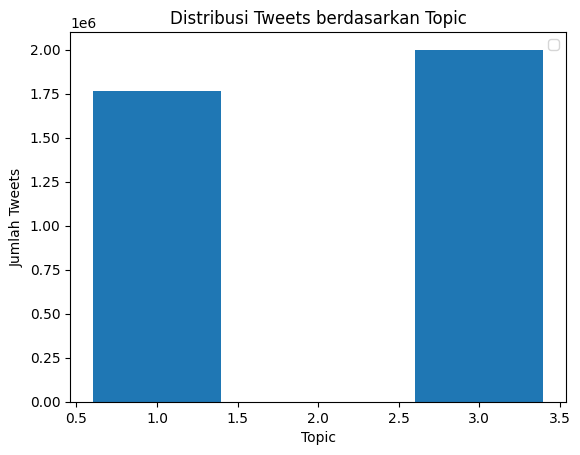

In [43]:
create_bar_plot(df)

# *Line Plot Topics*

In [40]:
def create_stacked_line_plot(df, interval='D'):
    # Memastikan kolom `created_at` bertipe datetime
    df['created_at'] = pd.to_datetime(df['created_at'])

    # Agregasi data berdasarkan `topic` dan interval waktu
    df_agg = df.set_index('created_at').resample(interval)['topic'].value_counts().unstack().fillna(0)

    # Membuat line plot bertumpuk
    plt.figure(figsize=(12, 6))
    plt.stackplot(df_agg.index, df_agg.values.T, labels=df_agg.columns)
    plt.xlabel('Waktu')
    plt.ylabel('Jumlah Kemunculan')
    plt.title(f'Tren Kemunculan Topik per {interval}')
    plt.legend(title='Topik')
    plt.show()

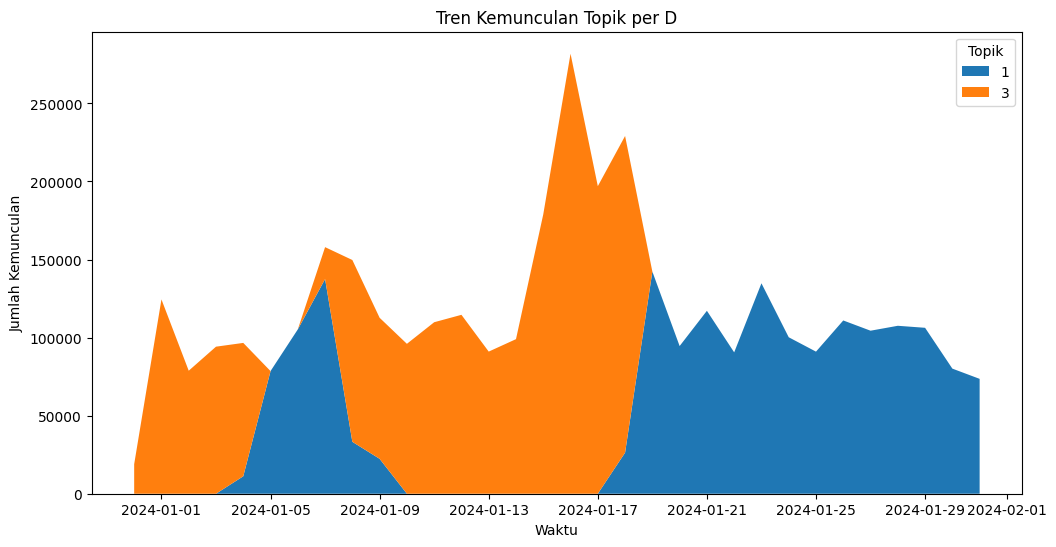

In [41]:
create_stacked_line_plot(df)

# *Boxplot Retweet and Topic*

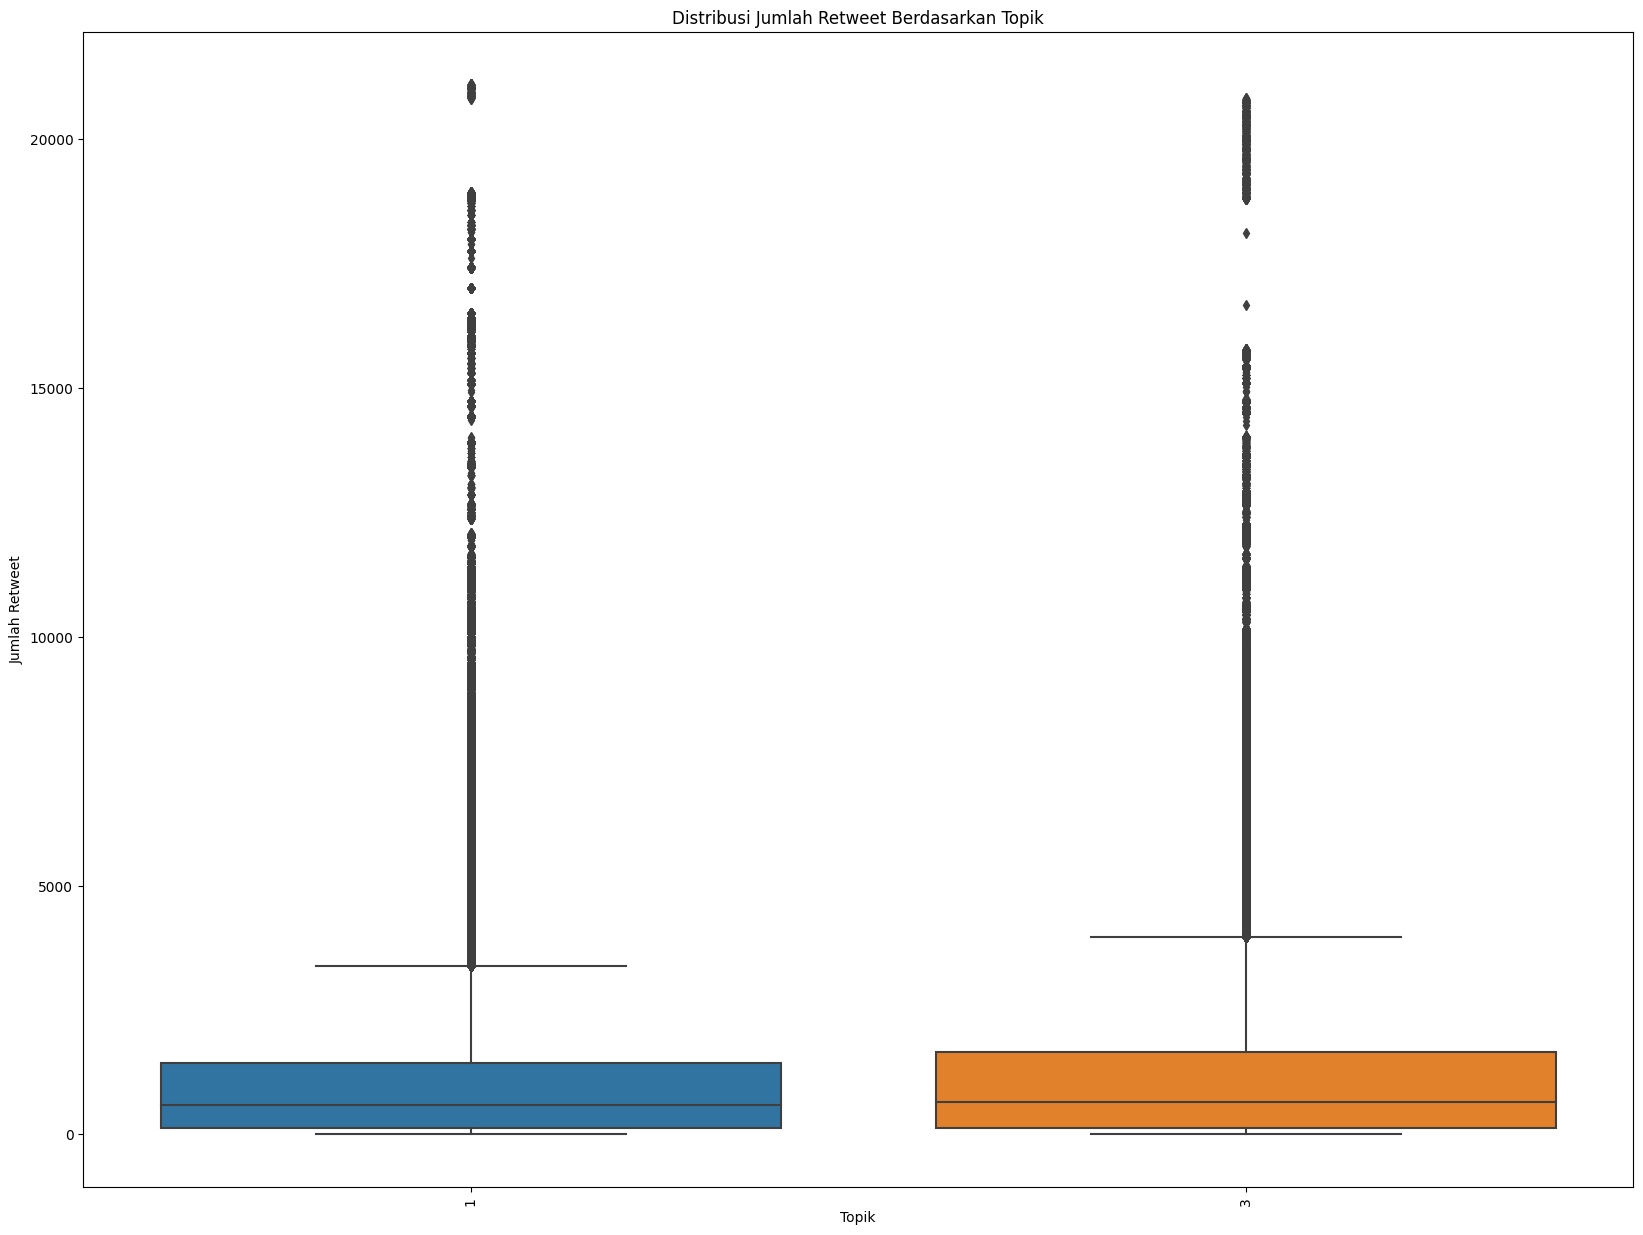

In [50]:
# Box Plot
plt.figure(figsize=(20, 15))
sns.boxplot(x='topic', y='num_retweets', data=df)
plt.xlabel('Topik')
plt.ylabel('Jumlah Retweet')
plt.title('Distribusi Jumlah Retweet Berdasarkan Topik')
plt.xticks(rotation=90)
plt.show()

# *Boxplot Follower and Topics*

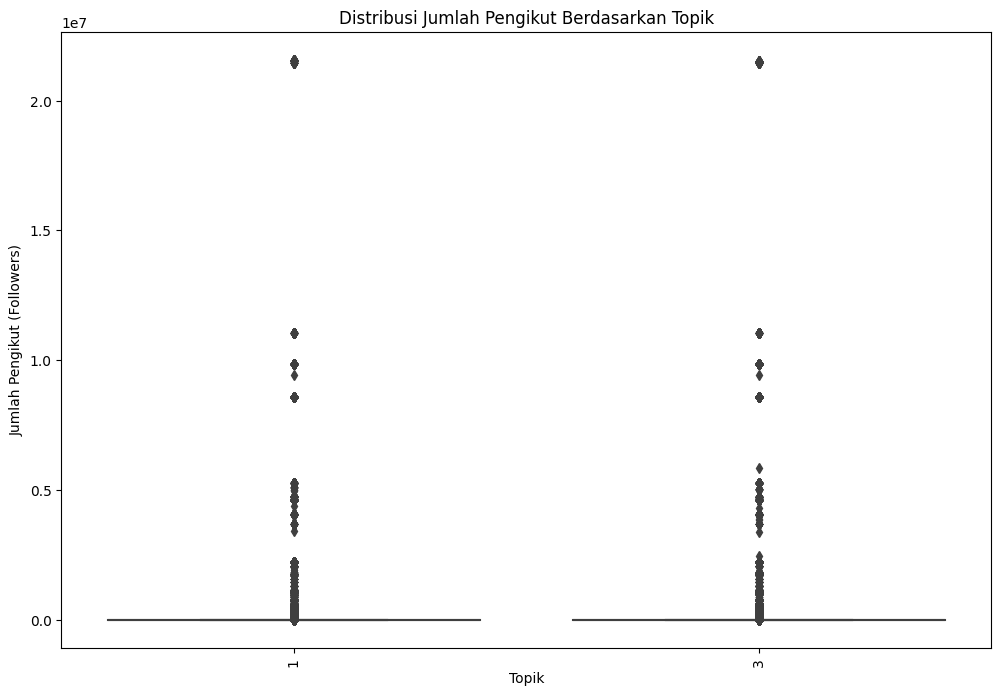

In [51]:
# Box Plot
plt.figure(figsize=(20,15))
sns.boxplot(x='topic', y='flw_cnt', data=df)
plt.xlabel('Topik')
plt.ylabel('Jumlah Pengikut (Followers)')
plt.title('Distribusi Jumlah Pengikut Berdasarkan Topik')
plt.xticks(rotation=90)
plt.show()

# *Boxplot Following with Topics*

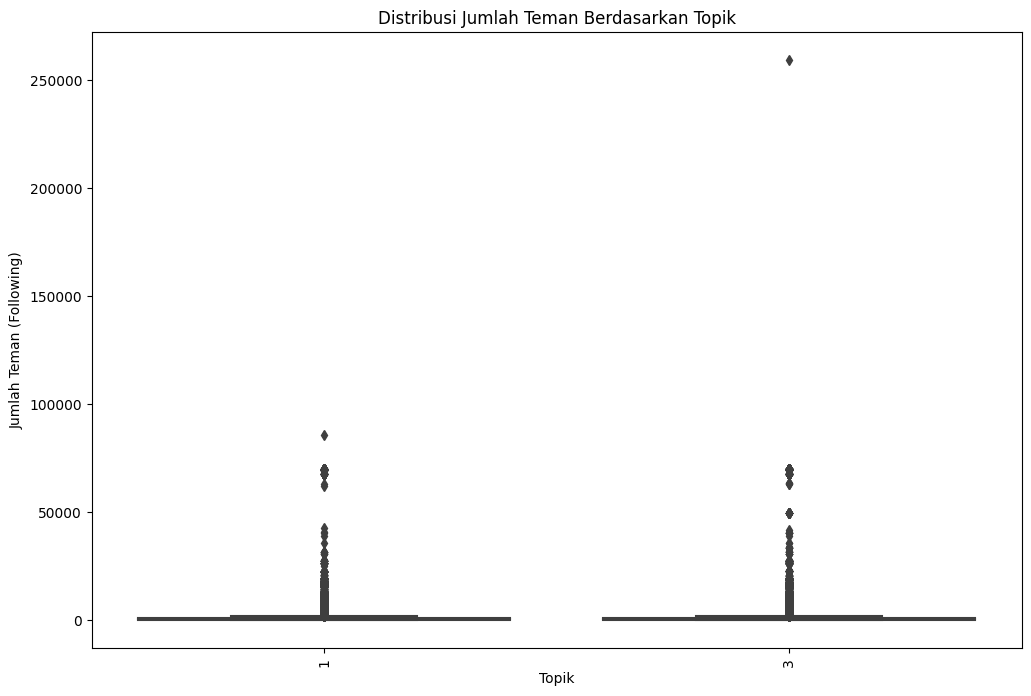

In [52]:
# Box Plot
plt.figure(figsize=(20,15))
sns.boxplot(x='topic', y='frn_cnt', data=df)
plt.xlabel('Topik')
plt.ylabel('Jumlah Teman (Following)')
plt.title('Distribusi Jumlah Teman Berdasarkan Topik')
plt.xticks(rotation=90)
plt.show()

# *Boxplot Status with Topics*

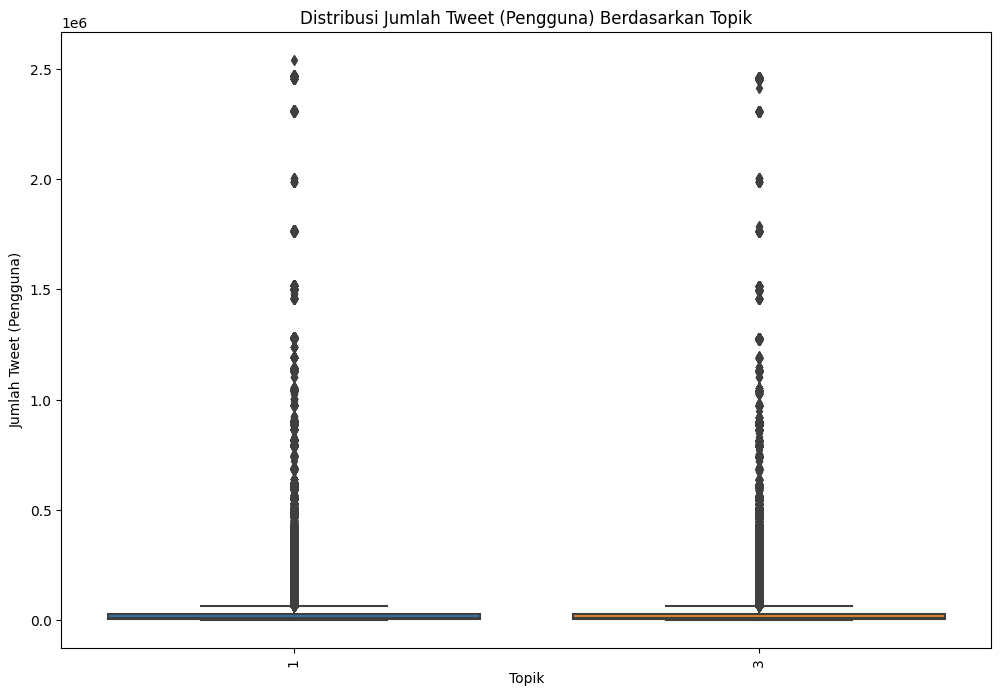

In [56]:
# Box Plot
plt.figure(figsize=(20,15))
sns.boxplot(x='topic', y='sts_cnt', data=df)
plt.xlabel('Topik')
plt.ylabel('Jumlah Tweet (Pengguna)')
plt.title('Distribusi Jumlah Tweet (Pengguna) Berdasarkan Topik')
plt.xticks(rotation=90)
plt.show()

# *Boxplot List with Topics*

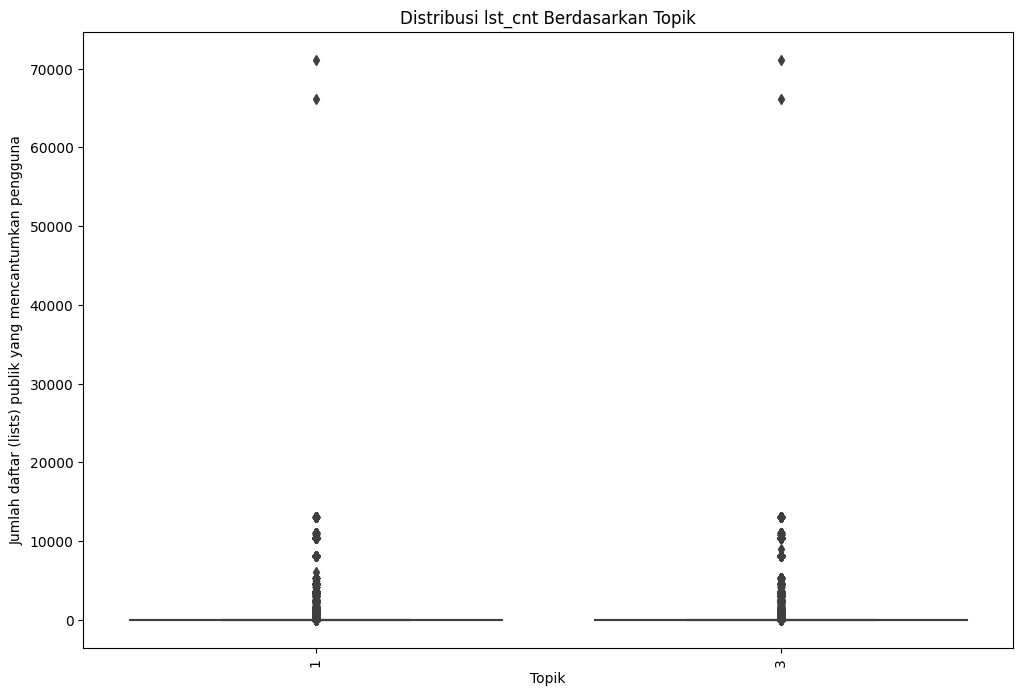

In [57]:
# Box Plot
plt.figure(figsize=(20,15))
sns.boxplot(x='topic', y='lst_cnt', data=df)
plt.xlabel('Topik')
plt.ylabel('Jumlah daftar (lists) publik yang mencantumkan pengguna')
plt.title('Distribusi lst_cnt Berdasarkan Topik')
plt.xticks(rotation=90)
plt.show()

# *Type of Tweets berdasarkan Topics*

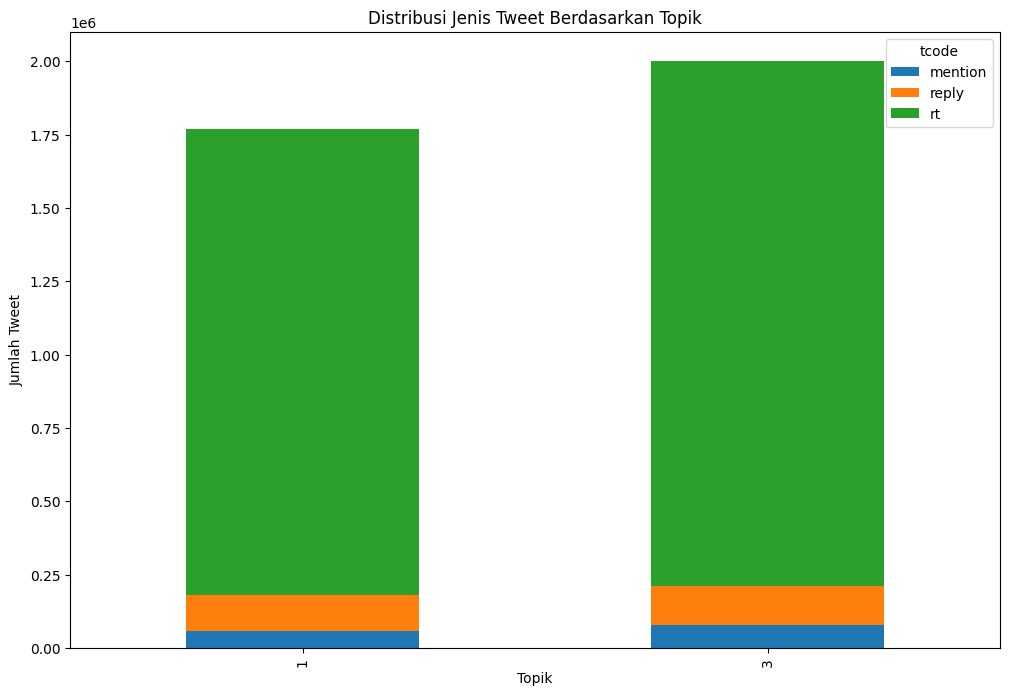

In [53]:
tweet_type_counts = df.groupby(['topic', 'tcode']).size().unstack().fillna(0)
tweet_type_counts.plot(kind='bar', stacked=True, figsize=(20,15))
plt.xlabel('Topik')
plt.ylabel('Jumlah Tweet')
plt.title('Distribusi Jenis Tweet Berdasarkan Topik')
plt.xticks(rotation=90)
plt.show()

# *Jumlah Retweet vs. Pengikut Berdasarkan Topik (Heatmap)*

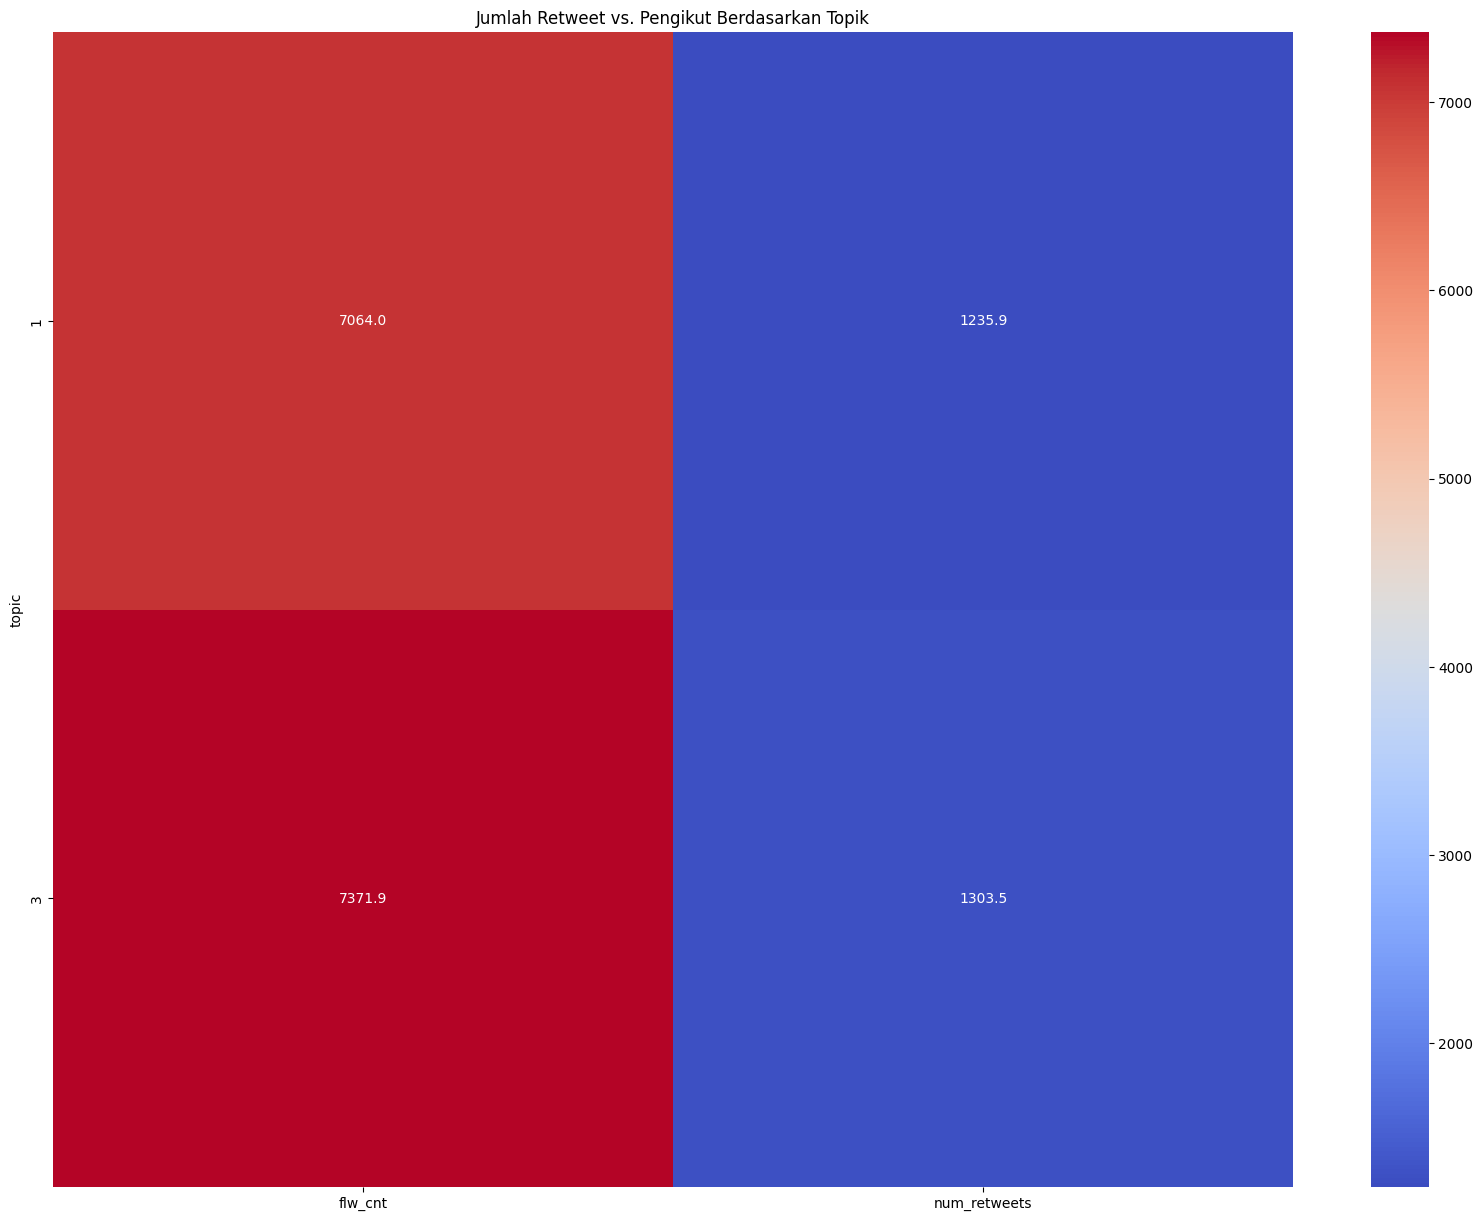

In [55]:
# Heatmap
plt.figure(figsize=(20, 15))
heatmap_data = df.pivot_table(index='topic', values=['num_retweets', 'flw_cnt'], aggfunc='mean')
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap='coolwarm')
plt.title('Jumlah Retweet vs. Pengikut Berdasarkan Topik')
plt.show()